# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import time
import string
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import tweepy
from tweepy import OAuthHandler 
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already u

# Selenium Driver to scrap Tweets

In [77]:
class SeleniumClient(object):
    
    def __init__(self):

        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')


        self.browser = webdriver.Chrome('D:\Data Science Python Programs\TWEET SENTIMENT ANALYSIS', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q=Deep%20Learning&src=typed_query'

    def get_tweets(self, query):
 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('AI')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('Deep-Learning')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

# Twitter API Keys

In [3]:
consumer_key = #Confidential#
consumer_secret = #Confidential#
access_token = #Confidential#
access_token_secret = #Confidential#

# Tweepy OAuthHandler for Tweets Extraction

In [78]:
class TwitterClient(object): 
    
    
    def __init__(self): 
  
        try: 
     
            auth = OAuthHandler(consumer_key, consumer_secret) 
      
            auth.set_access_token(access_token, access_token_secret) 
            
            
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 5000):
       
    
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 


                    if tweet.retweet_count > 0: 

                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:

                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [79]:
twitter_client = TwitterClient()


tweets_df = twitter_client.get_tweets('AI and Deep learning', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1899 tweets
Downloaded 1999 tweets
Downloaded 2099 tweets
Downloaded 2199 tweets
Downloaded 2299 tweets
Downloaded 2399 tweets
Downloaded 2499 tweets
Downloaded 2599 tweets
Downloaded 2699 tweets
Downloaded 2799 tweets
Downloaded 2899 tweets
Downloaded 2999 tweets
Downloaded 3020 tweets
No more tweets found
tweets_df Shape - (1105, 1)


,tweets
0,RT @into_AI: Deep Learning Chipset Market Size...
1,"Deep Learning Chipset Market Size, New Growth ..."
2,Research Team from KAIST Develops a Technology...
3,"RT @omarsar0: whenever you see ""machine learni..."
4,RT @alisher_ai: International AI and Brain Sci...
5,RT @cackerman1: DEEP COMPRESSION: COMPRESSING ...
6,New post: stc and NVIDIA Team Up to Build Saud...
7,RT @IAM__Network: Deep learning takes on synth...
8,Deep learning takes on synthetic biology: Comp...
9,RT @BlackfreeNiken: Complete #Tensorflow 2 and...


# Sentiment Polarity Using TextBlob

In [16]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [17]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,1063
neg,84


In [18]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,971
neg,176


In [19]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,"RT @omarsar0: whenever you see ""machine learni...",pos
1,RT @alisher_ai: International AI and Brain Sci...,pos
2,RT @cackerman1: DEEP COMPRESSION: COMPRESSING ...,pos
3,New post: stc and NVIDIA Team Up to Build Saud...,pos
4,RT @IAM__Network: Deep learning takes on synth...,pos


# Text Preproccessing

In [20]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [25]:
# tweets_df['tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df =tweets_df.applymap(lambda s:s.lower() if type(s) == str else s)
tweets_df.head(10)

,tweets,sentiment
0,"whenever you see ""machine learning/deep learn...",pos
1,international ai and brain science symposium ...,pos
2,deep compession: compessing deep neual netwok...,pos
3,new post: stc and nvidia team up to build saud...,pos
4,deep learning takes on synthetic biology: com...,pos
5,deep learning takes on synthetic biology: comp...,pos
6,complete #tensorflow 2 and keras deep learnin...,pos
7,to understand the challenges of developing ai ...,pos
8,a lightning-fast introduction to deep learning...,pos
9,"using original footage by lumiere, this snowb...",pos


In [26]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment
0,"whenever you see ""machine learning/deep learni...",pos
1,international ai and brain science symposium w...,pos
2,deep compession: compessing deep neual netwoks...,pos
3,new post: stc and nvidia team up to build saud...,pos
4,deep learning takes on synthetic biology: comp...,pos
5,deep learning takes on synthetic biology: comp...,pos
6,complete #tensorflow 2 and keras deep learning...,pos
7,to understand the challenges of developing ai ...,pos
8,a lightning-fast introduction to deep learning...,pos
9,"using original footage by lumiere, this snowba...",pos


In [27]:
tweets_df = tweets_df[tweets_df['tweets']!='']
tweets_df.head()

,tweets,sentiment
0,"whenever you see ""machine learning/deep learni...",pos
1,international ai and brain science symposium w...,pos
2,deep compession: compessing deep neual netwoks...,pos
3,new post: stc and nvidia team up to build saud...,pos
4,deep learning takes on synthetic biology: comp...,pos


In [28]:
tweets_df.drop_duplicates(subset=['tweets'], keep=False)
tweets_df = tweets_df.reset_index(drop=True)
tweets_df['tweets'] = tweets_df['tweets'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head()

,tweets,sentiment
0,whenever you see machine learningdeep learning...,pos
1,international ai and brain science symposium w...,pos
2,deep compession compessing deep neual netwoks ...,pos
3,new post stc and nvidia team up to build saudi...,pos
4,deep learning takes on synthetic biology compu...,pos


In [29]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment
0,whenever see machine learningdeep learningai e...,pos
1,international ai brain science symposium held ...,pos
2,deep compession compessing deep neual netwoks ...,pos
3,new post stc nvidia team build saudi arabias f...,pos
4,deep learning takes synthetic biology computat...,pos
5,deep learning takes synthetic biology computat...,pos
6,complete keras deep learning bootcamp,pos
7,understand challenges developing ai frameworks...,pos
8,lightningfast introduction deep learning tenso...,pos
9,using original footage lumiere snowball fight ...,pos


In [30]:
tokenized_tweet = tweets_df['tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [whenever, see, machine, learningdeep, learnin...
1    [international, ai, brain, science, symposium,...
2    [deep, compession, compessing, deep, neual, ne...
3    [new, post, stc, nvidia, team, build, saudi, a...
4    [deep, learning, takes, synthetic, biology, co...
Name: tweets, dtype: object

In [31]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [whenever, see, machine, learningdeep, learnin...
1    [international, ai, brain, science, symposium,...
2    [deep, compession, compessing, deep, neual, ne...
3    [new, post, stc, nvidia, team, build, saudi, a...
4    [deep, learning, take, synthetic, biology, com...
Name: tweets, dtype: object

In [32]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment
0,whenever see machine learningdeep learningai e...,pos
1,international ai brain science symposium held ...,pos
2,deep compession compessing deep neual netwoks ...,pos
3,new post stc nvidia team build saudi arabia fi...,pos
4,deep learning take synthetic biology computati...,pos
5,deep learning take synthetic biology computati...,pos
6,complete kera deep learning bootcamp,pos
7,understand challenge developing ai framework d...,pos
8,lightningfast introduction deep learning tenso...,pos
9,using original footage lumiere snowball fight ...,pos


In [33]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [34]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [35]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['machine learningdeep learningai', 'minute line code sentence run'],
 ['international brain science symposium', 'wonderful speaker world htt'],
 ['deep compession', 'deep neual netwoks', 'tained quantization huffman'],
 ['new post stc nvidia team',
  'saudi',
  'first deep learning cloud infrastructure'],
 ['synthetic biology computational algorithm enable identification optimization'],
 ['synthetic biology computational algorithm enable identification optimization ofnaba'],
 ['complete kera deep learning bootcamp'],
 ['understand challenge', 'framework deep learning model regional language'],
 ['lightningfast introduction', 'tensorflow'],
 ['original footage', 'snowball fight lyon france']]

In [36]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():

    words_without_hash = [word for word in row.tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['machine learningdeep learningai', 'minute line code sentence'],
 ['brain science symposium', 'october wonderful speaker world htt'],
 ['deep compession', 'quantization huffman coding'],
 ['new post stc nvidia team',
  'saudi arabia first',
  'deep learning cloud infrastructure'],
 ['synthetic biology computational algorithm', 'identification optimization'],
 ['synthetic biology computational algorithm',
  'identification optimization ofnaba'],
 ['complete kera deep'],
 ['model regional language'],
 ['lightningfast introduction deep'],
 ['original footage lumiere snowball fight lyon france']]

In [37]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,key_phrases
0,whenever see machine learningdeep learningai e...,pos,"[machine learningdeep learningai, minute line ..."
1,international ai brain science symposium held ...,pos,"[brain science symposium, october wonderful sp..."
2,deep compession compessing deep neual netwoks ...,pos,"[deep compession, quantization huffman coding]"
3,new post stc nvidia team build saudi arabia fi...,pos,"[new post stc nvidia team, saudi arabia first,..."
4,deep learning take synthetic biology computati...,pos,"[synthetic biology computational algorithm, id..."
5,deep learning take synthetic biology computati...,pos,"[synthetic biology computational algorithm, id..."
6,complete kera deep learning bootcamp,pos,[complete kera deep]
7,understand challenge developing ai framework d...,pos,[model regional language]
8,lightningfast introduction deep learning tenso...,pos,[lightningfast introduction deep]
9,using original footage lumiere snowball fight ...,pos,[original footage lumiere snowball fight lyon ...


# WordCloud Generation

In [38]:
from wordcloud import WordCloud
def wordcloud(x):
    plt.figure(figsize=(14, 10))
    wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(x))
    plt.imshow(wordcloud)
    plt.axis("off")
    return wordcloud

In [39]:
all_words = ' '.join([text for text in tweets_df['tweets'][tweets_df.sentiment == 'pos']])

In [40]:
all_wordss = all_words.split()

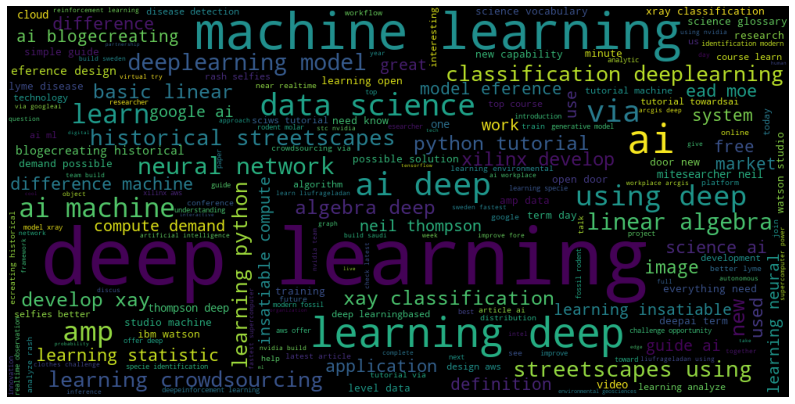

In [41]:
wordcloud(all_wordss)

In [42]:
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

In [43]:
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['tweets'])

In [44]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [45]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [46]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()
    
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

Accuracy Score - 0.8971061093247589


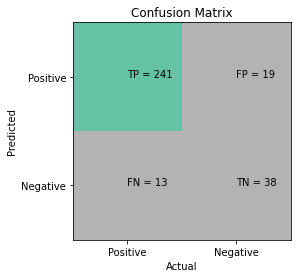

In [47]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.8971061093247589


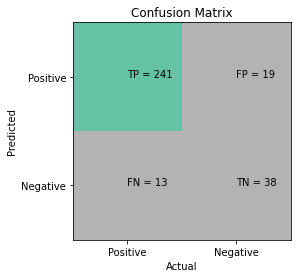

In [48]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.8231511254019293


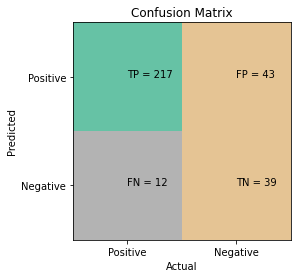

In [49]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [53]:
tweets_df = tweets_df[['tweets','sentiment']]
tweets_df['sentiment'] = np.where(tweets_df['sentiment'] == 'pos', 1, 0)
tweets_df.head()

,tweets,sentiment
0,whenever see machine learningdeep learningai e...,1
1,international ai brain science symposium held ...,1
2,deep compession compessing deep neual netwoks ...,1
3,new post stc nvidia team build saudi arabia fi...,1
4,deep learning take synthetic biology computati...,1


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_df['tweets'], tweets_df['sentiment'], \
                                                    test_size=0.1, random_state=0)

# Recurrent Neural Network Modeling with LSTM

In [61]:
top_words = 40000
maxlen = 120 
batch_size = 64
nb_classes = 4
nb_epoch = 100

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Sequential

tokenizer = Tokenizer(nb_words=top_words) #only consider top 40000 words in the corpse
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

C:\Users\DELL\anaconda3\envs\MLPython env\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [57]:
X_train_seq.shape,X_test_seq.shape,y_train_seq.shape,y_test_seq.shape

((1032, 120), (115, 120), (1032, 4), (115, 4))

In [62]:
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU

model1 = Sequential()

model1.add(Embedding(top_words, 128))

model1.add(LSTM(128))
model1.add(Dropout(0.2))

model1.add(Dense(4))

model1.add(Dense(4))

model1.add(Dense(4))

model1.add(Dense(4))

model1.add(Dense(4))

model1.add(Dense(4))

model1.add(Activation('softmax'))
model1.summary()


model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [63]:
model1.fit(X_train_seq, y_train_seq, batch_size=batch_size,epochs=nb_epoch, verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 270ms/step - loss: 0.4747 - accuracy: 0.7413
Epoch 2/100
17/17 [==============================] - 4s 252ms/step - loss: 0.2777 - accuracy: 0.8430
Epoch 3/100
17/17 [==============================] - 4s 253ms/step - loss: 0.2280 - accuracy: 0.8430
Epoch 4/100
17/17 [==============================] - 4s 255ms/step - loss: 0.2220 - accuracy: 0.8430
Epoch 5/100
17/17 [==============================] - 4s 253ms/step - loss: 0.2179 - accuracy: 0.8430
Epoch 6/100
17/17 [==============================] - 4s 252ms/step - loss: 0.2050 - accuracy: 0.8430
Epoch 7/100
17/17 [==============================] - 2s 134ms/step - loss: 0.1506 - accuracy: 0.8643
Epoch 8/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0605 - accuracy: 0.9758
Epoch 9/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0210 - accuracy: 0.9903
Epoch 10/100
17/17 [==============================] - 2s 132ms/step - loss: 0.0170 - accura

17/17 [==============================] - 3s 182ms/step - loss: 0.0013 - accuracy: 0.9981
Epoch 81/100
17/17 [==============================] - 3s 190ms/step - loss: 5.8730e-04 - accuracy: 0.9990
Epoch 82/100
17/17 [==============================] - 3s 186ms/step - loss: 0.0012 - accuracy: 0.9981
Epoch 83/100
17/17 [==============================] - 3s 190ms/step - loss: 9.6239e-04 - accuracy: 0.9981
Epoch 84/100
17/17 [==============================] - 3s 193ms/step - loss: 7.3889e-04 - accuracy: 0.9990
Epoch 85/100
17/17 [==============================] - 3s 180ms/step - loss: 0.0011 - accuracy: 0.9990
Epoch 86/100
17/17 [==============================] - 3s 189ms/step - loss: 6.6385e-04 - accuracy: 0.9990
Epoch 87/100
17/17 [==============================] - 3s 184ms/step - loss: 0.0012 - accuracy: 0.9981
Epoch 88/100
17/17 [==============================] - 3s 188ms/step - loss: 8.5607e-04 - accuracy: 0.9990
Epoch 89/100
17/17 [==============================] - 3s 192ms/step - loss:

In [64]:
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

2/2 [==============================] - 0s 17ms/step - loss: 0.2434 - accuracy: 0.9565
Test loss : 0.2434
Test accuracy : 0.9565
